In [1]:
from head import opentrons_Euclidian 
import pandas as pd
import numpy as np
from scipy.spatial import distance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

INFO: Using numpy backend


In [2]:
class Simulator:
    def __init__(self):
        self.domain = np.linspace(-5,5,num=100)
        
    def load_data(self):
        for i in range(0,9):
            df = pd.read_excel('Training Data/Spectra_Itr' + str(i) + '.xlsx')
            df = df.dropna(axis=1)
            df = df.drop(columns = ['Wavelength'])
            array = np.asarray(df)
            array = array.T
            if i == 0:
                array_all = array
            else:
                array_all = np.vstack((array_all, array))
        self.y = array_all
        
        for i in range(0,9):
            df = pd.read_csv('Training Data/Volumes_Itr' + str(i) + '.csv')
            df = df.dropna(axis=1)
            df = df.drop(columns = ['Unnamed: 0'])
            array = np.asarray(df)
            if array.shape[0] == 16:
                array = array[0:-1,:]
            if i == 0:
                array_all = array
            else:
                array_all = np.vstack((array_all, array))
        array_all = array_all[:,1:]
        self.x = array_all
        
    def train_model(self):
        self.lr = LinearRegression().fit(self.x, self.y)
        print(self.lr.score(self.x, self.y))
        
    def predict(self,x):
        return self.lr.predict(x)
        
    def generate(self, mu, sig):
        scale = 1/(np.sqrt(2*np.pi)*sig)
        return scale*np.exp(-np.power(self.domain - mu, 2.) / (2 * np.power(sig, 2.)))
    
    def process_batch(self, Cb, fname):
        out = []
        for c in Cb:
            out.append(self.generate(*c))
        out = np.asarray(out)
        df = pd.DataFrame(out.T, index=self.domain)
        df.to_excel(fname, engine='openpyxl')
        return 
    
    def process_batch_2(self, Cb, fname):
        df = self.predict(Cb)
        df = pd.DataFrame(df.T, columns = ['CTAB', 'GC', 'AG', 'AA'])
        df.to_excel(fname, engine='openpyxl')
        return 
    
    def make_target(self, ct):
        return self.domain, self.generate(*ct)

In [3]:
sim = Simulator()
sim.load_data()
sim.train_model()

0.4364560360939898


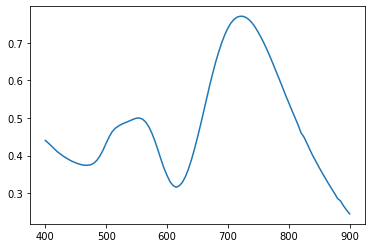

In [4]:
plt.plot(np.linspace(400,900,101).reshape(-1,1), sim.predict(np.array([400,200,100,50,125]).reshape(1,-1)).reshape(-1,1))

In [5]:
CTAB = [20,450]
GC = [20,350]
AG = [20,150]
AA = [20,150]
SEEDS = [20,150]
bounds = [CTAB, GC, AG, AA, SEEDS]

In [6]:
xt = np.linspace(400,900,101).reshape(-1,1)
yt = sim.predict(np.array([400,200,100,50,125]).reshape(1,-1)).reshape(-1,1)

In [7]:
optim = opentrons_Euclidian.Optimizer(xt, yt, bounds, 
                            savedir = 'Data/', batch_size=4)

INFO: Getting suggestions for iteration 0


In [9]:
# random iteration
optim.save()
C0 = np.load('Data/0/new_x.npy')
sim.process_batch_2(C0, 'Data/0.xlsx')
optim.update('Data/0.xlsx')
optim.save()

INFO: Current experiment id : 0
INFO: Iteration : 1
INFO: 0	[370.08123457  86.13073945  23.39821268 115.81062615  79.1336289 ]	[[-1.6554622  -1.66646445 -1.68126309 -1.70089364 -1.72266604 -1.74266653
  -1.76357411 -1.78269021 -1.80194154 -1.81930226 -1.83468204 -1.84738784
  -1.85872303 -1.86425232 -1.86390712 -1.85656442 -1.83694714 -1.80345353
  -1.75673075 -1.70856189 -1.66672405 -1.64518776 -1.64054122 -1.64375391
  -1.64824417 -1.6536837  -1.65845524 -1.66347558 -1.66983273 -1.67677879
  -1.68243033 -1.68289315 -1.67621847 -1.66214442 -1.6468357  -1.64066759
  -1.65698478 -1.70806147 -1.79343211 -1.90266105 -2.00829633 -2.10840317
  -2.17498362 -2.20493442 -2.17940727 -2.12200163 -2.0302534  -1.91806774
  -1.80125206 -1.70247181 -1.64652694 -1.65164706 -1.72743332 -1.86721606
  -2.05833253 -2.27006081 -2.49426023 -2.70255621 -2.90465179 -3.08025645
  -3.22766322 -3.34660221 -3.42801647 -3.48190558 -3.50362976 -3.50128623
  -3.47221932 -3.41971317 -3.34199634 -3.2432298  -3.125868

RuntimeError: wrong batch shape

In [151]:
for i in range(1,5):
    # iteration i selection
    optim.suggest_next()
    optim.save()
    # simulate iteration i new_x 
    Ci = np.load('Data/%d/new_x.npy'%i)
    #sim.process_batch(Ci, 'Data/%d.xlsx'%i)
    optim.update('Data/%d.xlsx'%i)
    optim.save()

INFO: Getting suggestions for iteration 1


AttributeError: 'Optimizer' object has no attribute 'mll'